In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import cv2
import h5py
from IPython import display
from matplotlib_inline import backend_inline



In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [11]:
import h5py
import matplotlib.pyplot as plt

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'


# 读取HDF5文件
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    # 假设第一个数据集是我们要看的
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())



数据集列表: ['Velocity_0001', 'Velocity_0002', 'Velocity_0003', 'Velocity_0004', 'Velocity_0005', 'Velocity_0006', 'Velocity_0007', 'Velocity_0008', 'Velocity_0009', 'Velocity_0010', 'Velocity_0011', 'Velocity_0012', 'Velocity_0013', 'Velocity_0014', 'Velocity_0015', 'Velocity_0016', 'Velocity_0017', 'Velocity_0018', 'Velocity_0019', 'Velocity_0020', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


In [12]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'

# 读取HDF5文件
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    # 假设第一个数据集是我们要看的
    dataset_name = datasets[0]
    data = f[dataset_name][()]
    print(f"{dataset_name} 数据形状:", data.shape)
    print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
    
    # 归一化数据到 [0, 1] 范围
    data_normalized = (data[0] - data.min()) / (data.max() - data.min())
    
    # # 可视化数据中的第一个通道
    # plt.imshow(data_normalized[:, :, 0], cmap='viridis')
    # plt.title(f'{dataset_name} 第一个通道')
    # plt.colorbar()
    # plt.show()
    
    # # 可视化数据中的第二个通道
    # plt.imshow(data_normalized[:, :, 1], cmap='viridis')
    # plt.title(f'{dataset_name} 第二个通道')
    # plt.colorbar()
    # plt.show()
    
    # # 可视化数据中的第三个通道
    # plt.imshow(data_normalized[:, :, 2], cmap='viridis')
    # plt.title(f'{dataset_name} 第三个通道')
    # plt.colorbar()
    # plt.show()

数据集列表: ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422


In [13]:
import h5py
import numpy as np

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'

# 读取HDF5文件并检查每个 Velocity 数据集的基本信息
with h5py.File(file_path, 'r') as f:
    # 查看文件中所有的数据集
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    for dataset_name in datasets:
        if 'Velocity' in dataset_name:
            data = f[dataset_name][()]
            print(f"{dataset_name} 数据形状:", data.shape)
            print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
            print(f"{dataset_name} 数据均值:", data.mean())
            print(f"{dataset_name} 数据标准差:", data.std())
            print()


数据集列表: ['Velocity_0001', 'Velocity_0002', 'Velocity_0003', 'Velocity_0004', 'Velocity_0005', 'Velocity_0006', 'Velocity_0007', 'Velocity_0008', 'Velocity_0009', 'Velocity_0010', 'Velocity_0011', 'Velocity_0012', 'Velocity_0013', 'Velocity_0014', 'Velocity_0015', 'Velocity_0016', 'Velocity_0017', 'Velocity_0018', 'Velocity_0019', 'Velocity_0020', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422
Velocity_0001 数据均值: 0.07109838
Velocity_0001 数据标准差: 0.6888756

Velocity_0002 数据形状: (1, 1024, 1024, 3)
Velocity_0002 数据范围: -2.7356367 到 2.7098155
Velocity_0002 数据均值: 0.07116876
Velocity_0002 数据标准差: 0.68889195

Velocity_0003 数据形状: (1, 1024, 1024, 3)
Velocity_0003 数据范围: -2.722479 到 2.7283216
Velocity_0003 数据均值: 0.07122495
Velocity_0003 数据标准差: 0.688922

Velocity_0004 数据形状: (1, 1024, 1024, 3)
Velocity_0004 数据范围: -2.7307792 到 2.74634
Velocity_0004 数据均值: 0.07126973
Velocity_0004 数据标准差: 0.6889681

Velocity_0005 数据形状: (1, 1024, 1024, 3)
Velocity_0

# 定义所需要的函数

## 计算涡度

In [14]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy


# 计算归一化的涡度
def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized


## 绘制动态所需函数

In [15]:
# 定义Animator类和其他辅助函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats("svg")

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

In [16]:
class Animator:
    """For plotting data in animation."""
    def __init__(
        self,
        xlabels=[None, None],
        ylabels=[None, None],
        legends=[None, None],
        xlims=[None, None],
        ylims=[None, None],
        xscales=["linear", "linear"],
        yscales=["linear", "linear"],
        fmts=["c--", "m", "g--", "r"],
        nrows=1,
        ncols=2,
        figsize=(10, 4),
    ):
        use_svg_display()
        if legends is None:
            legends = [[], []]
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.config_axes = lambda: (
            set_axes(
                self.axes[0],
                xlabels[0],
                ylabels[0],
                xlims[0],
                ylims[0],
                xscales[0],
                yscales[0],
                legends[0],
            ),
            set_axes(
                self.axes[1],
                xlabels[1],
                ylabels[1],
                xlims[1],
                ylims[1],
                xscales[1],
                yscales[1],
                legends[1],
            ),
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[1].cla()
        for i, (x, y, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if i < 2:
                self.axes[0].plot(x, y, fmt)
            else:
                self.axes[1].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)


# 预训练模型测试新的湍流非对称数据集

读取约翰霍普金斯的湍流数据库

In [17]:
def downsample(image, size=(64, 64)):
    return cv2.resize(image, size, interpolation=cv2.INTER_AREA)


### 原始数据集

In [18]:
## 读取测试集

file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_test.h5'

with h5py.File(file_path,'r') as f :
    datasets = list(f.keys())
    print("数据集列表:", datasets)
    
    for dataset_name in datasets:
        if 'Velocity' in dataset_name:
            data = f[dataset_name][()]
            print(f"{dataset_name} 数据形状:", data.shape)
            print(f"{dataset_name} 数据范围:", data.min(), "到", data.max())
            print(f"{dataset_name} 数据均值:", data.mean())
            print(f"{dataset_name} 数据标准差:", data.std())
            print()

    data_normalized = (data[0] - data.min()) / (data.max() - data.min())

    data = f[dataset_name][()]

    u_test = data_normalized[:,:,0]
    v_test = data_normalized[:,:,1]
    w_test = data_normalized[:,:,2]



数据集列表: ['Velocity_0001', 'xcoor', 'ycoor', 'zcoor']
Velocity_0001 数据形状: (1, 1024, 1024, 3)
Velocity_0001 数据范围: -2.712391 到 2.6947422
Velocity_0001 数据均值: 0.07109838
Velocity_0001 数据标准差: 0.6888756



### 降采样数据集 （64*64）

In [19]:
# 读取HDF5文件并降采样
with h5py.File(file_path, 'r') as f:
    # 获取所有速度场数据集名称
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    
    # 初始化空列表用于存储所有数据
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        # 取出三通道的速度场数据
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        # 降采样
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        # 将数据转换为PyTorch张量并增加batch和channel维度
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        # 合并速度场作为输入
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        
        all_velocity_fields.append(velocity_field)
    
    # 将所有速度场数据合并为一个大的张量
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0)
    
    # 目标abcd (假设为0初始化)
    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32)
    
    # 创建数据集和数据加载器
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=1, shuffle=True)  # 你可以根据需要调整batch_size

# 检查数据形状
print("all_velocity_fields shape:", all_velocity_fields.shape)
print("target_abcd shape:", target_abcd.shape)


all_velocity_fields shape: torch.Size([1, 3, 64, 64])
target_abcd shape: torch.Size([1, 4, 64, 64])


In [20]:
target_abcd.shape

torch.Size([1, 4, 64, 64])

In [21]:
all_velocity_fields[0,1,0,:].shape

torch.Size([64])

In [22]:
#可以查看数据范围，xyz都是（0，$2\pi$）
size_low = 64

dx = 2*np.pi/size_low
dy = 2*np.pi/size_low
dz = 2*np.pi/size_low

In [23]:
u_test =all_velocity_fields[0,0,:,:].numpy()
v_test =all_velocity_fields[0,1,:,:].numpy()
w_test =all_velocity_fields[0,2,:,:].numpy()

In [24]:
vort_test = vorticity(u_test, v_test, dx, dx)

vorticity_normalized = vorticity_normalize(vort_test)

print(vort_test.shape)
print(vorticity_normalized.shape)

(64, 64)
(64, 64)


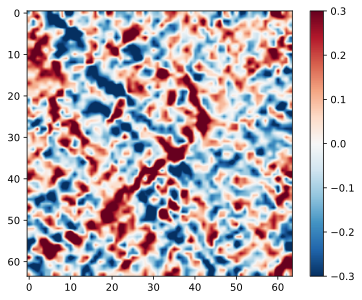

In [25]:
plt.imshow(vorticity_normalized, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()

u速度场形状 (64, 64)
v速度场形状 (64, 64)


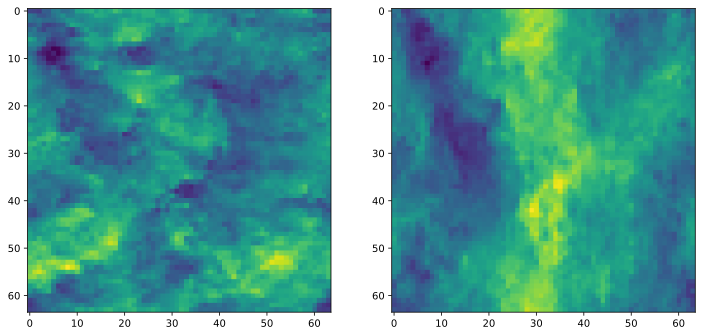

In [26]:
print("u速度场形状",u_test.shape) 
print("v速度场形状",v_test.shape)

# 查看一些速度场   
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)   
plt.imshow(u_test, cmap='viridis')   
plt.subplot(1, 2, 2)
plt.imshow(v_test, cmap='viridis')

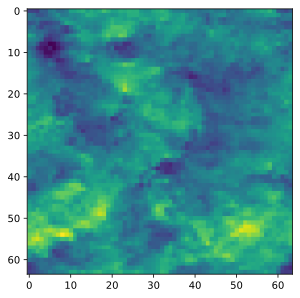

In [27]:
plt.imshow(u_test, cmap='viridis')

# 模型A部分尝试更换数据集

In [28]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [29]:
# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'


In [30]:
with h5py.File(file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        # 假设已定义降采样函数downsample
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_velocity_fields.append(velocity_field)
    
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0).to(device)  # 确保数据在GPU上

    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)  # 目标也在GPU上
    
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)


In [31]:
class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)
        x = self.conv5(x)
        return x

In [32]:
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        
        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)  # Skip connection
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)  # Skip connection
        x = F.relu(self.bn7(self.conv7(x)))
        
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)  # Skip connection
        x = F.relu(self.bn8(self.conv8(x)))
        
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)  # Skip connection
        x = F.relu(self.bn9(self.conv9(x)))
        
        x = self.conv10(x)
        return x


In [33]:
class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)
        x = x / norm
        return x


In [34]:
class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x


In [35]:
class ConstraintLayer(nn.Module):
    def __init__(self):
        super(ConstraintLayer, self).__init__()

    def forward(self, x):
        # 假设x的形状为 [batch_size, 4, height, width]，其中4代表abcd
        norm = torch.sqrt(x[:, 0, :, :]**2 + x[:, 1, :, :]**2 + x[:, 2, :, :]**2 + x[:, 3, :, :]**2 + 1e-8)
        norm = norm.unsqueeze(1)  # 为了与abcd的四个通道对齐
        x = x / norm  # 归一化
        return x

class ModelAWithConstraints(nn.Module):
    def __init__(self):
        super(ModelAWithConstraints, self).__init__()
        self.model = BasicModelA()
        self.constraint_layer = ConstraintLayer()

    def forward(self, x):
        x = self.model(x)
        x = self.constraint_layer(x)
        return x

def calculate_gradients_with_numpy(tensor):
    # 确保 Tensor 不需要梯度跟踪，且在 CPU 上
    tensor_np = tensor.detach().cpu().numpy()

    # 计算梯度
    grad_x = np.gradient(tensor_np, axis=1)  # 假设水平方向是 axis=1
    grad_y = np.gradient(tensor_np, axis=2)  # 假设垂直方向是 axis=2
    
    # 转换回 Tensor
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    
    return grad_x_tensor, grad_y_tensor

def laplacian_2d(array, dx, dy):
    grad_x = np.gradient(array, dx, axis=1, edge_order=2)  # 计算 x 方向的一阶导数
    grad_y = np.gradient(array, dy, axis=0, edge_order=2)  # 计算 y 方向的一阶导数
    
    laplacian_x = np.gradient(grad_x, dx, axis=1, edge_order=2)  # 计算 x 方向的二阶导数
    laplacian_y = np.gradient(grad_y, dy, axis=0, edge_order=2)  # 计算 y 方向的二阶导数
    
    return laplacian_x + laplacian_y



def laplacian_2d_torch(tensor, dx, dy):
    # 确保tensor是浮点类型，因为梯度计算通常需要浮点运算
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()

    # 计算x和y方向的一阶导数
    grad_x = np.gradient(tensor_np, axis=1)  # x方向
    grad_y = np.gradient(tensor_np, axis=2)  # y方向

    # 计算x和y方向的二阶导数
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)

    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)

    # 相加得到完整的拉普拉斯算子
    laplacian = laplacian_x_tensor + laplacian_y_tensor

    return laplacian


In [36]:
def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):
    # 确保计算都在GPU上
    predicted_abcd = predicted_abcd.to(device)
    true_velocity = true_velocity.to(device)
    
    # 提取 a, b, c, d
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    # 计算梯度
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1

    # 计算预测的速度场
    # U_x_pred = hbar * (a * b_grad_x - b * a_grad_x)
    # U_y_pred = hbar * (c * d_grad_y - d * c_grad_y)
    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    # 真实的速度场
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    # 计算速度场的损失
    loss_velocity = F.mse_loss(U_magnitude_pred, U_magnitude_true) + F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true)
    
    # 计算归一化约束
    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))
    
    # 计算拉普拉斯算子
    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    # 计算螺旋度约束
    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    # 计算L1正则化项
    l1_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())

    # 计算L2正则化项
    l2_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    
    # 计算正则化项
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    # 总损失
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization # + norm_constraint + curl_constraint + regularization_term 
    return total_loss


In [37]:
learning_rate = 0.001
num_epochs = 20000
epsilon = 0.01
l1_lambda = 0.001  # L1正则化系数
l2_lambda = 0.001  # L2正则化系数


channels = 3

model = ComplexModelA()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
# 模型和优化器
model = ComplexModelA().to(device)  # 转移模型到GPU
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [39]:
# 训练循环
for epoch in range(num_epochs):
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)  # 确保数据在GPU上
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        
        # 计算损失
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)
        
        # 反向传播
        loss.backward()
        optimizer.step()
        
        if i % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}], Loss: {loss.item():.4f}')


Epoch [1/20000], Step [1], Loss: 135.8635
Epoch [2/20000], Step [1], Loss: 45.1164
Epoch [3/20000], Step [1], Loss: 25.6313
Epoch [4/20000], Step [1], Loss: 17.7839
Epoch [5/20000], Step [1], Loss: 13.7452
Epoch [6/20000], Step [1], Loss: 11.4269
Epoch [7/20000], Step [1], Loss: 10.3740
Epoch [8/20000], Step [1], Loss: 9.6981
Epoch [9/20000], Step [1], Loss: 9.1964
Epoch [10/20000], Step [1], Loss: 8.9917
Epoch [11/20000], Step [1], Loss: 8.6890
Epoch [12/20000], Step [1], Loss: 8.4792
Epoch [13/20000], Step [1], Loss: 8.3372
Epoch [14/20000], Step [1], Loss: 8.1671
Epoch [15/20000], Step [1], Loss: 7.9538
Epoch [16/20000], Step [1], Loss: 7.9218
Epoch [17/20000], Step [1], Loss: 7.7306
Epoch [18/20000], Step [1], Loss: 7.6583
Epoch [19/20000], Step [1], Loss: 7.5484
Epoch [20/20000], Step [1], Loss: 7.4596
Epoch [21/20000], Step [1], Loss: 7.2967
Epoch [22/20000], Step [1], Loss: 7.2965
Epoch [23/20000], Step [1], Loss: 7.1195
Epoch [24/20000], Step [1], Loss: 7.0594
Epoch [25/20000],

KeyboardInterrupt: 

In [40]:
predicted_abcd[1,1,:,:].shape

torch.Size([64, 64])

In [41]:
a_pre = predicted_abcd[1,0,:,:].detach().cpu().numpy()
b_pre = predicted_abcd[1,1,:,:].detach().cpu().numpy()
c_pre = predicted_abcd[1,2,:,:].detach().cpu().numpy()
d_pre = predicted_abcd[1,3,:,:].detach().cpu().numpy()


In [42]:
a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)

In [ ]:
# U_x_pred_test = a_pre * b_test_grad_x - b_pre * a_test_grad_x + c_pre * d_test_grad_x - d_pre * c_test_grad_x
# U_y_pred_test = a_pre * b_test_grad_y - b_pre * a_test_grad_y + c_pre * d_test_grad_y - d_pre * c_test_grad_y
# U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

In [43]:
U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

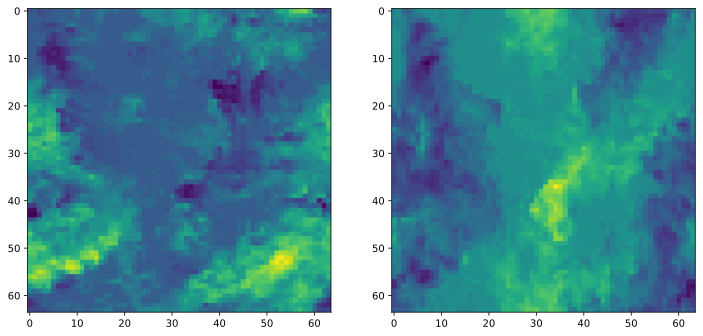

In [44]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
# plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')


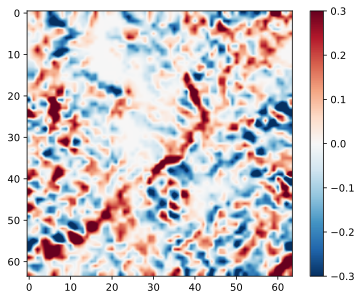

In [45]:
vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)

vorticity_normalized_pre = vorticity_normalize(vort_pre)

plt.imshow(vorticity_normalized_pre, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline


NameError: name 'dx' is not defined

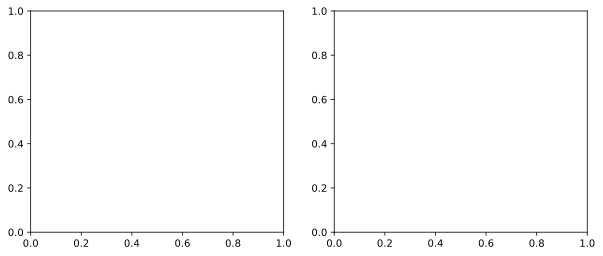

In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline

# 定义Animator类和其他辅助函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats("svg")

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(
        self,
        xlabels=[None, None],
        ylabels=[None, None],
        legends=[None, None],
        xlims=[None, None],
        ylims=[None, None],
        xscales=["linear", "linear"],
        yscales=["linear", "linear"],
        fmts=["c--", "m", "g--", "r"],
        nrows=1,
        ncols=2,
        figsize=(10, 4),
    ):
        use_svg_display()
        if legends is None:
            legends = [[], []]
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.config_axes = lambda: (
            set_axes(
                self.axes[0],
                xlabels[0],
                ylabels[0],
                xlims[0],
                ylims[0],
                xscales[0],
                yscales[0],
                legends[0],
            ),
            set_axes(
                self.axes[1],
                xlabels[1],
                ylabels[1],
                xlims[1],
                ylims[1],
                xscales[1],
                yscales[1],
                legends[1],
            ),
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[1].cla()
        for i, (x, y, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if i < 2:
                self.axes[0].plot(x, y, fmt)
            else:
                self.axes[1].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 设定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'

# 读取HDF5文件并降采样
with h5py.File(file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        # 假设已定义降采样函数downsample
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_velocity_fields.append(velocity_field)
    
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0).to(device)  # 确保数据在GPU上

    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)  # 目标也在GPU上
    
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

class BasicModelA(nn.Module):
    def __init__(self):
        super(BasicModelA, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.upsample = nn.Upsample(scale_factor=8, mode='bilinear', align_corners=True)
        self.conv5 = nn.Conv2d(512, 4, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.upsample(x)
        x = self.conv5(x)
        return x

class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        
        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)  # Skip connection
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)  # Skip connection
        x = F.relu(self.bn7(self.conv7(x)))
        
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)  # Skip connection
        x = F.relu(self.bn8(self.conv8(x)))
        
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)  # Skip connection
        x = F.relu(self.bn9(self.conv9(x)))
        
        x = self.conv10(x)
        return x

def calculate_gradients_with_numpy(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    return grad_x_tensor, grad_y_tensor

def laplacian_2d_torch(tensor, dx, dy):
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)
    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)
    laplacian = laplacian_x_tensor + laplacian_y_tensor
    return laplacian

def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):
    predicted_abcd = predicted_abcd.to(device)
    true_velocity = true_velocity.to(device)
    
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1

    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    loss_velocity = F.mse_loss(U_magnitude_pred, U_magnitude_true) + F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true)
    
    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))
    
    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    l1_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())

    l2_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization # + norm_constraint + curl_constraint + regularization_term 
    return total_loss

# 超参数和训练设置
learning_rate = 0.001
num_epochs = 1000
epsilon = 0.01
l1_lambda = 0.001
l2_lambda = 0.001

model = ComplexModelA().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 设置动画器
animator = Animator(
    xlabels=["epoch", "epoch"],
    ylabels=["Loss", "Metric"],
    legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
    xlims=[[1, num_epochs], [1, num_epochs]],
    ylims=[[0, 10], [0, 10]]
)

# 训练循环
for epoch in range(num_epochs):
    train_loss_sum = 0.0
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    
    train_loss = train_loss_sum / len(dataloader)
    val_loss = 0  # 可以根据需求添加验证集损失计算
    val_metric = 0  # 可以根据需求添加验证集指标计算

    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_loss:.4f}')
    
    # 添加到动画器
    animator.add(epoch + 1, (train_loss, val_loss, train_loss, val_metric))

# 预测和结果展示
predicted_abcd = model(all_velocity_fields)
predicted_abcd = predicted_abcd.detach().cpu().numpy()
a_pre = predicted_abcd[1, 0, :, :]
b_pre = predicted_abcd[1, 1, :, :]
c_pre = predicted_abcd[1, 2, :, :]
d_pre = predicted_abcd[1, 3, :, :]

a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)

U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)




In [ ]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')

vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)
vorticity_normalized_pre = vorticity_normalize(vort_pre)
plt.imshow(vorticity_normalized_pre, cmap='RdBu_r', vmin=-0.3, vmax=0.3, interpolation='bilinear')
plt.colorbar()

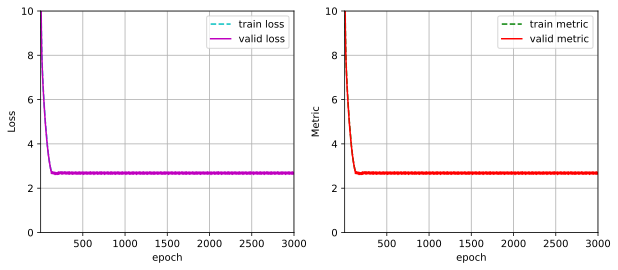

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
from matplotlib import pyplot as plt
from IPython import display
from matplotlib_inline import backend_inline

# 定义Animator类和其他辅助函数
def use_svg_display():
    """Use the svg format to display a plot in Jupyter."""
    backend_inline.set_matplotlib_formats("svg")

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib."""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim), axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

class Animator:
    """For plotting data in animation."""
    def __init__(
        self,
        xlabels=[None, None],
        ylabels=[None, None],
        legends=[None, None],
        xlims=[None, None],
        ylims=[None, None],
        xscales=["linear", "linear"],
        yscales=["linear", "linear"],
        fmts=["c--", "m", "g--", "r"],
        nrows=1,
        ncols=2,
        figsize=(10, 4),
    ):
        use_svg_display()
        if legends is None:
            legends = [[], []]
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        self.config_axes = lambda: (
            set_axes(
                self.axes[0],
                xlabels[0],
                ylabels[0],
                xlims[0],
                ylims[0],
                xscales[0],
                yscales[0],
                legends[0],
            ),
            set_axes(
                self.axes[1],
                xlabels[1],
                ylabels[1],
                xlims[1],
                ylims[1],
                xscales[1],
                yscales[1],
                legends[1],
            ),
        )
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        self.axes[1].cla()
        for i, (x, y, fmt) in enumerate(zip(self.X, self.Y, self.fmts)):
            if i < 2:
                self.axes[0].plot(x, y, fmt)
            else:
                self.axes[1].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

# 设定设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 文件路径
file_path = r'D:\\zjPhD\\turbulenceData\\turbulenceData\\isotropic1024coarse_10.h5'
validation_file_path = r'D:\zjPhD\turbulenceData\turbulenceData\isotropic1024coarse_test.h5'

def downsample(data, size=64):
    """简单的降采样函数，将数据从1024x1024降采样到64x64。"""
    scale = data.shape[0] // size
    return data[::scale, ::scale]

# 读取训练数据集并降采样
with h5py.File(file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_velocity_fields.append(velocity_field)
    
    all_velocity_fields = torch.cat(all_velocity_fields, dim=0).to(device)  # 确保数据在GPU上

    num_samples = all_velocity_fields.shape[0]
    size_low = all_velocity_fields.shape[2]
    target_abcd = torch.zeros((num_samples, 4, size_low, size_low), dtype=torch.float32).to(device)
    
    dataset = TensorDataset(all_velocity_fields, target_abcd)
    dataloader = DataLoader(dataset, batch_size=2, shuffle=True)

# 读取验证数据集并降采样
with h5py.File(validation_file_path, 'r') as f:
    velocity_datasets = [name for name in f.keys() if 'Velocity' in name]
    all_validation_velocity_fields = []
    
    for dataset_name in velocity_datasets:
        data = f[dataset_name][()]
        U_x = data[0, :, :, 0]
        U_y = data[0, :, :, 1]
        U_magnitude = data[0, :, :, 2]
        
        U_x_downsampled = downsample(U_x)
        U_y_downsampled = downsample(U_y)
        U_magnitude_downsampled = downsample(U_magnitude)
        
        U_x_tensor = torch.tensor(U_x_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_y_tensor = torch.tensor(U_y_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        U_magnitude_tensor = torch.tensor(U_magnitude_downsampled, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
        
        velocity_field = torch.cat((U_x_tensor, U_y_tensor, U_magnitude_tensor), dim=1)
        all_validation_velocity_fields.append(velocity_field)
    
    all_validation_velocity_fields = torch.cat(all_validation_velocity_fields, dim=0).to(device)
    num_samples_val = all_validation_velocity_fields.shape[0]
    target_abcd_val = torch.zeros((num_samples_val, 4, size_low, size_low), dtype=torch.float32).to(device)
    
    validation_dataset = TensorDataset(all_validation_velocity_fields, target_abcd_val)
    validation_dataloader = DataLoader(validation_dataset, batch_size=2, shuffle=False)

# 定义模型
class ComplexModelA(nn.Module):
    def __init__(self):
        super(ComplexModelA, self).__init__()
        # Encoder
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(512)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(1024)
        
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.bn6 = nn.BatchNorm2d(512)
        
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.bn8 = nn.BatchNorm2d(128)
        
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.bn9 = nn.BatchNorm2d(64)
        
        self.conv10 = nn.Conv2d(64, 4, kernel_size=3, padding=1)
        
    def forward(self, x):
        # Encoder
        x1 = F.relu(self.bn1(self.conv1(x)))
        x2 = self.pool(x1)
        x2 = F.relu(self.bn2(self.conv2(x2)))
        x3 = self.pool(x2)
        x3 = F.relu(self.bn3(self.conv3(x3)))
        x4 = self.pool(x3)
        x4 = F.relu(self.bn4(self.conv4(x4)))
        x5 = self.pool(x4)
        x5 = F.relu(self.bn5(self.conv5(x5)))
        
        # Decoder
        x = self.upconv1(x5)
        x = torch.cat((x, x4), dim=1)  # Skip connection
        x = F.relu(self.bn6(self.conv6(x)))
        
        x = self.upconv2(x)
        x = torch.cat((x, x3), dim=1)  # Skip connection
        x = F.relu(self.bn7(self.conv7(x)))
        
        x = self.upconv3(x)
        x = torch.cat((x, x2), dim=1)  # Skip connection
        x = F.relu(self.bn8(self.conv8(x)))
        
        x = self.upconv4(x)
        x = torch.cat((x, x1), dim=1)  # Skip connection
        x = F.relu(self.bn9(self.conv9(x)))
        
        x = self.conv10(x)
        return x

def calculate_gradients_with_numpy(tensor):
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    grad_x_tensor = torch.from_numpy(grad_x).to(tensor.device)
    grad_y_tensor = torch.from_numpy(grad_y).to(tensor.device)
    return grad_x_tensor, grad_y_tensor

def laplacian_2d_torch(tensor, dx, dy):
    tensor = tensor.float()
    tensor_np = tensor.detach().cpu().numpy()
    grad_x = np.gradient(tensor_np, axis=1)
    grad_y = np.gradient(tensor_np, axis=2)
    laplacian_x = np.gradient(grad_x, axis=1)
    laplacian_y = np.gradient(grad_y, axis=2)
    laplacian_x_tensor = torch.from_numpy(laplacian_x).to(tensor.device)
    laplacian_y_tensor = torch.from_numpy(laplacian_y).to(tensor.device)
    laplacian = laplacian_x_tensor + laplacian_y_tensor
    return laplacian

def loss_function(predicted_abcd, true_velocity, model, epsilon, l1_lambda=0.0, l2_lambda=0.0):
    predicted_abcd = predicted_abcd.to(device)
    true_velocity = true_velocity.to(device)
    
    a = predicted_abcd[:, 0, :, :]
    b = predicted_abcd[:, 1, :, :]
    c = predicted_abcd[:, 2, :, :]
    d = predicted_abcd[:, 3, :, :]
    
    a_grad_x, a_grad_y = calculate_gradients_with_numpy(a)
    b_grad_x, b_grad_y = calculate_gradients_with_numpy(b)
    c_grad_x, c_grad_y = calculate_gradients_with_numpy(c)
    d_grad_x, d_grad_y = calculate_gradients_with_numpy(d)

    hbar = 1

    U_x_pred = a + b
    U_y_pred = c + d
    U_magnitude_pred = torch.sqrt(U_x_pred**2 + U_y_pred**2)
    
    U_x_true = true_velocity[:, 0, :, :]
    U_y_true = true_velocity[:, 1, :, :]
    U_magnitude_true = true_velocity[:, 2, :, :]

    loss_velocity = F.mse_loss(U_magnitude_pred, U_magnitude_true) + F.mse_loss(U_x_pred, U_x_true) + F.mse_loss(U_y_pred, U_y_true)
    
    norm = a**2 + b**2 + c**2 + d**2
    norm_constraint = F.mse_loss(norm, torch.ones_like(norm))
    
    lap_b = laplacian_2d_torch(b, dx, dx)
    lap_a = laplacian_2d_torch(a, dx, dx)
    lap_d = laplacian_2d_torch(d, dx, dx)
    lap_c = laplacian_2d_torch(c, dx, dx)

    curl_constraint = (a * lap_b - b * lap_a + c * lap_d - d * lap_c).sum()
    
    l1_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l1_lambda > 0:
        l1_regularization = sum(torch.sum(torch.abs(param)) for param in model.parameters())

    l2_regularization = torch.tensor(0., requires_grad=True).to(device)
    if l2_lambda > 0:
        l2_regularization = sum(torch.sum(param**2) for param in model.parameters())
    
    regularization_term = epsilon * 0.25 * (torch.sum(a**2) + torch.sum(b**2) + torch.sum(c**2) + torch.sum(d**2))
    
    total_loss = loss_velocity + l1_lambda * l1_regularization + l2_lambda * l2_regularization # + norm_constraint + curl_constraint + regularization_term 
    return total_loss

# 超参数和训练设置
learning_rate = 0.001
num_epochs = 3000
epsilon = 0.01
l1_lambda = 0.001
l2_lambda = 0.001

model = ComplexModelA().to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# 设置动画器
animator = Animator(
    xlabels=["epoch", "epoch"],
    ylabels=["Loss", "Metric"],
    legends=[["train loss", "valid loss"], ["train metric", "valid metric"]],
    xlims=[[1, num_epochs], [1, num_epochs]],
    ylims=[[0, 10], [0, 10]]
)

# 训练循环
for epoch in range(num_epochs):
    train_loss_sum = 0.0
    for i, (velocity, _) in enumerate(dataloader):
        velocity = velocity.to(device)
        optimizer.zero_grad()
        predicted_abcd = model(velocity)
        loss = loss_function(predicted_abcd, velocity, model, epsilon, l1_lambda, l2_lambda)
        loss.backward()
        optimizer.step()
        train_loss_sum += loss.item()
    
    train_loss = train_loss_sum / len(dataloader)
    
    # 计算验证损失
    val_loss_sum = 0.0
    with torch.no_grad():
        for velocity_val, _ in validation_dataloader:
            velocity_val = velocity_val.to(device)
            predicted_abcd_val = model(velocity_val)
            val_loss = loss_function(predicted_abcd_val, velocity_val, model, epsilon, l1_lambda, l2_lambda)
            val_loss_sum += val_loss.item()
    
    val_loss = val_loss_sum / len(validation_dataloader)

    # 打印训练和验证损失
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    
    # 更新动画器
    animator.add(epoch + 1, (train_loss, val_loss, train_loss, val_loss))




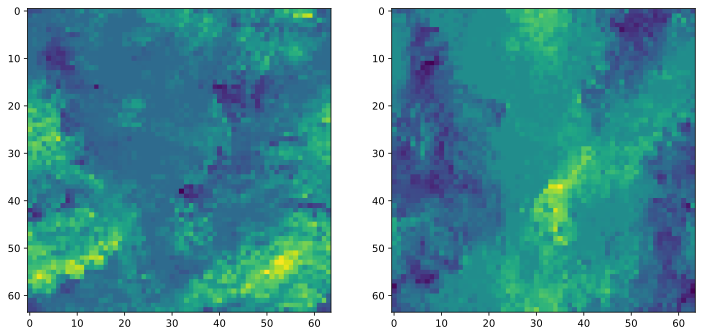

In [6]:
# 预测和结果展示
predicted_abcd = model(all_velocity_fields)
predicted_abcd = predicted_abcd.detach().cpu().numpy()
a_pre = predicted_abcd[1, 0, :, :]
b_pre = predicted_abcd[1, 1, :, :]
c_pre = predicted_abcd[1, 2, :, :]
d_pre = predicted_abcd[1, 3, :, :]

a_test_grad_x, a_test_grad_y = np.gradient(a_pre, dx)
b_test_grad_x, b_test_grad_y = np.gradient(b_pre, dx)
c_test_grad_x, c_test_grad_y = np.gradient(c_pre, dx)
d_test_grad_x, d_test_grad_y = np.gradient(d_pre, dx)

U_x_pred_test = a_pre + b_pre
U_y_pred_test = c_pre + d_pre
U_magnitude_pred_test = np.sqrt(U_x_pred_test**2 + U_y_pred_test**2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(U_x_pred_test, cmap='viridis')
plt.subplot(1, 2, 2)
plt.imshow(U_y_pred_test, cmap='viridis')

In [7]:
def vorticity(U_x, U_y, dx, dy):
    dU_y_dx, _ = np.gradient(U_y, dx, axis=0), np.gradient(U_y, dy, axis=1)
    _, dU_x_dy = np.gradient(U_x, dx, axis=0), np.gradient(U_x, dy, axis=1)
    return dU_y_dx - dU_x_dy


# 计算归一化的涡度
def vorticity_normalize(vorticity):
    max_vorticity = np.max(np.abs(vorticity))
    vort_normalized = vorticity / max_vorticity if max_vorticity != 0 else vorticity
    return vort_normalized

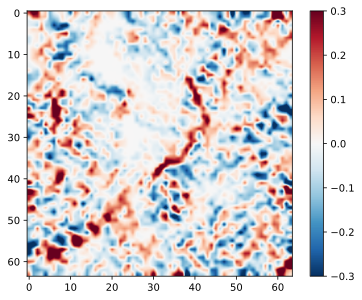

In [8]:
vort_pre = vorticity(U_x_pred_test, U_y_pred_test, dx, dx)

vorticity_normalized_pre = vorticity_normalize(vort_pre)

plt.imshow(vorticity_normalized_pre, cmap='RdBu_r',vmin=-0.3,vmax=0.3,interpolation='bilinear')
plt.colorbar()